# Anomaly Detection with H2O Deep Autoencoder Networks

## Anomaly Heart Beats Detection

The dataset is an ECG time series of heartbeats and the goal
is to determine which heartbeats are outliers. The training data (20 “good”
heartbeats) and the test data (training data with 3 “bad” heartbeats appended
for simplicity) can be downloaded directly into the H2O cluster, as shown below.
Each row represents a single heartbeat.

In [1]:
import h2o
from h2o.estimators.deeplearning import H2OAutoEncoderEstimator
h2o.init()

ERROR:h2o:Key init.version_check is not a valid config key


Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O cluster uptime:,12 hours 19 mins
H2O cluster version:,3.16.0.1
H2O cluster version age:,6 days
H2O cluster name:,H2O_started_from_R_avkashchauhan_uii589
H2O cluster total nodes:,1
H2O cluster free memory:,3.243 Gb
H2O cluster total cores:,8
H2O cluster allowed cores:,8
H2O cluster status:,"locked, healthy"
H2O connection url:,http://localhost:54321
H2O connection proxy:,None


In [2]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt

In [3]:
train_ecg = h2o.import_file("https://raw.githubusercontent.com/Avkash/mldl/master/data/ecg_discord_train.csv")
test_ecg = h2o.import_file("https://raw.githubusercontent.com/Avkash/mldl/master/data/ecg_discord_test.csv")

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


let's explore the dataset.

In [4]:
train_ecg.shape

(20, 210)

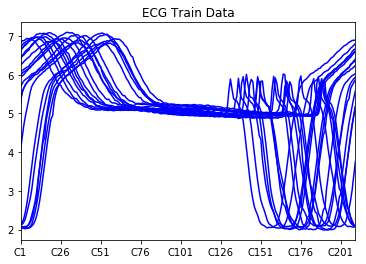

In [5]:
# transpose the frame to have the time serie as a single colum to plot
train_ecg.as_data_frame().T.plot(legend=False, title="ECG Train Data", color='blue'); # don't display the legend

in the train data we have 20 time series each of 210 data points. Notice that all the lines are compact and follow a similar shape. Is important to remember that when training with autoencoders you want to use only VALID data. All the anomalies should be removed.

Now let's use the AutoEncoderEstimator to train our neural network

In [6]:
model = H2OAutoEncoderEstimator( 
        activation="Tanh", 
        hidden=[50], 
        l1=1e-5,
        score_interval=0,
        epochs=100
)

model.train(x=train_ecg.names, training_frame=train_ecg)             

deeplearning Model Build progress: |██████████████████████████████████████| 100%


In [7]:
model

Model Details
H2OAutoEncoderEstimator :  Deep Learning
Model Key:  DeepLearning_model_python_1512067532473_1


ModelMetricsAutoEncoder: deeplearning
** Reported on train data. **

MSE: 0.00197934989581
RMSE: 0.0444898853202
Scoring History: 


,timestamp,duration,training_speed,epochs,iterations,samples,training_rmse,training_mse
,2017-11-30 23:05:52,0.208 sec,0.00000 obs/sec,0.0,0,0.0,0.3743078,0.1401063
,2017-11-30 23:05:52,0.846 sec,3194 obs/sec,100.0,10,2000.0,0.0444899,0.0019793


Variable Importances: 


variable,relative_importance,scaled_importance,percentage
C22,1.0,1.0,0.0059617
C27,0.9657412,0.9657412,0.0057575
C137,0.9630180,0.9630180,0.0057413
C48,0.9628948,0.9628948,0.0057405
C182,0.9596129,0.9596129,0.0057210
---,---,---,---
C73,0.6626626,0.6626626,0.0039506
C106,0.6527057,0.6527057,0.0038913
C35,0.6500528,0.6500528,0.0038754
C3,0.6480817,0.6480817,0.0038637



See the whole table with table.as_data_frame()


Our Neural Network is now able to *Encode* the time series.

Now we try to Compute reconstruction error with the Anomaly detection function.
This is the Mean Square Error between output and input layers.
Low error means that the neural network is able to encode the input well, and that means is a "known" case.
A High error means that the neural network has not seen that example before and so is an anomaly.

In [8]:
reconstruction_error = model.anomaly(test_ecg)

Now the question is: Which of the test_ecg time series are most likely an anomaly? 

We can select the top N that have high error rate

In [9]:
df = reconstruction_error.as_data_frame()

In [10]:
df['Rank'] = df['Reconstruction.MSE'].rank(ascending=False)

In [11]:
df_sorted = df.sort_values('Rank')
df_sorted

,Reconstruction.MSE,Rank
21,9.764124,1.0
22,7.496915,2.0
20,2.790878,3.0
14,0.003956,4.0
0,0.003470,5.0
4,0.003269,6.0
18,0.003222,7.0
3,0.002996,8.0
13,0.002834,9.0
9,0.002536,10.0


In [12]:
anomalies = df_sorted[ df_sorted['Reconstruction.MSE'] > 1.0 ]
anomalies

,Reconstruction.MSE,Rank
21,9.764124,1.0
22,7.496915,2.0
20,2.790878,3.0


In [13]:
data = test_ecg.as_data_frame()

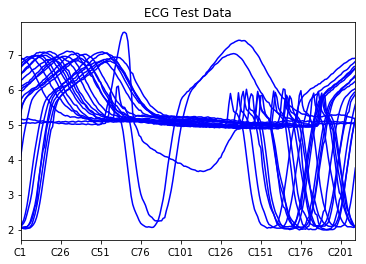

In [14]:
data.T.plot(legend=False, title="ECG Test Data", color='blue')

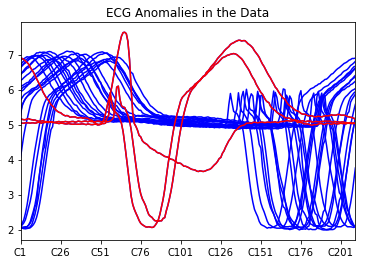

In [15]:
ax = data.T.plot(legend=False, color='blue')
data.T[anomalies.index].plot(legend=False, title="ECG Anomalies in the Data", color='red', ax=ax);

## Conclusions

In this tutorial you learned how to use the autoencoding capabilities of H2O to quickly detect time series anomalies using Autoencoders.